# Underfitting, Overfitting and Model Assessment

#### 🎯 Learning Goals

1. Understand the concepts of **Underfitting** and **Overfitting**.
2. Understand the concept of **Training**, **Validation**, and **Testing** datasets.

In [1]:
# Load our libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

import dsf_helpers as dsfh

# Use a nicer style for plots
plt.style.use("seaborn-v0_8-muted")

___

## Polynomial Regression

We have previously seen that linear regression models cover a wide range of models. Using the same technique, we can not only fit a **straight line** to the data, but also higher order polynomials, e.g. quadratic, cubic, or even higher order polynomials.

This is called **Polynomial Regression** and it is still considered linear regression, as the model is still linear in the parameters $\beta_0, \beta_1, \dots, \beta_k$.

To be formal, this means that we are considering the hypothesis class:

$$
\mathcal{H} = \left\{ f_{\boldsymbol{\beta}, k}(x) = \beta_0 + \beta_1 x + \beta_2 x^2 + \dots + \beta_k x^k \mid \beta_0, \beta_1, \dots, \beta_k \in \mathbb{R}, k \in \mathbb{N} \right\}.
$$

#### 🙀 🤯 Note on Polynomials vs. Orthogonal Polynomials

For this notebook, we will not exactly use polynomials as described above. Instead, we will use so called **orthogonal polynomials**. These are polynomials that are orthogonal to each other, i.e. the integral of the product of two different orthogonal polynomials is zero. We use orthogonal polynomials instead of polynomials as they help us better illustrate the concept of **overfitting**.

This is a fairly difficult concept and it is clearly out of scope for this course. However, since you have previously covered multicollinearity in class, you can think of orthogonal polynomials as *a way to avoid multicollinearity in polynomial regression*. This is not very precise, but it is a good intuition. For more information, you can check the [Wikipedia page](https://en.wikipedia.org/wiki/Orthogonal_polynomials) or the [Wolfram MathWorld page](https://mathworld.wolfram.com/OrthogonalPolynomials.html).

The code below implements a function that takes as input a vector `X` and the degree of the polynomial `k` and returns a matrix where the $k$-th column represents the value of the $k$-th orthogonal polynomial evaluated at the points in `X`. There is no need to understand the code. You will only need to use the function in the exercises below to create the $k$-th orthogonal polynomials.

In [2]:
# 🙀 🤯 Creates the orthogonal polynomial features
def poly(X, degree):
    X = np.array(X)
    # Transform X to a column vector if it is a 1D array
    if X.ndim == 1:
        X = X.reshape(-1, 1) 
    # Initial standard polynomial features
    n_samples, n_features = X.shape
    poly_features = np.column_stack([X**i for i in range(degree + 1)])

    # Gram-Schmidt orthogonalization
    ortho_features = np.zeros_like(poly_features)
    for i in range(poly_features.shape[1]):
        vector = poly_features[:, i]
        for j in range(i):
            vector -= (np.dot(poly_features[:, i], ortho_features[:, j]) /
                       np.dot(ortho_features[:, j], ortho_features[:, j])) * ortho_features[:, j]
        ortho_features[:, i] = vector

    # Normalize
    ortho_features = ortho_features / np.linalg.norm(ortho_features, axis=0)

    return ortho_features[:, 1:] # Remove the constant feature

In [3]:
# Begin by loading the data, the US crop yields data
crops = pd.read_csv("data/us_crops.csv")
# Sort values by temperature (for plotting later)
crops.sort_values(by="temp", inplace=True)
crops.head()

,temp,yield
21,8.05,252.145099
24,8.08,392.758514
81,8.15,943.882175
72,8.40,1150.373594
52,8.47,626.461877


#### ➡️ ✏️ Task 1

Write a function that computes the **mean squared error** of a model. The function should take as input the vector of true values `y_true` and the vector of predicted values `y_pred` and return the mean squared error.

The mean squared error is the empirical risk of the model under the squared loss function. It is defined as:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2.
$$

In [7]:
def mse(y_true, y_hat):
    return np.mean((y_true - y_hat)**2)

In [8]:
# Check that the function works
dsfh.check_mse(mse)

✅ Your function works perfectly!


In [9]:
# Store the temperature and yield data in separate variables
X = crops["temp"]
y = crops["yield"]

# List of polynomial degrees to model
degrees = [1, 2, 10, 20, 50]

models = []

for degree in degrees:
    # Create the polynomial features of the specified degree
    Xp = poly(crops["temp"], degree)

    # Fit a linear regression model to the polynomial features
    model = LinearRegression().fit(Xp, y)
    models.append(model)

    # Print the mean squared error of the model
    print(f"Degree {degree:>2} MSE: {mse(y, model.predict(Xp)):.2f}")

Degree  1 MSE: 51913.67
Degree  2 MSE: 39828.72
Degree 10 MSE: 36114.09
Degree 20 MSE: 28515.00
Degree 50 MSE: 19017.29


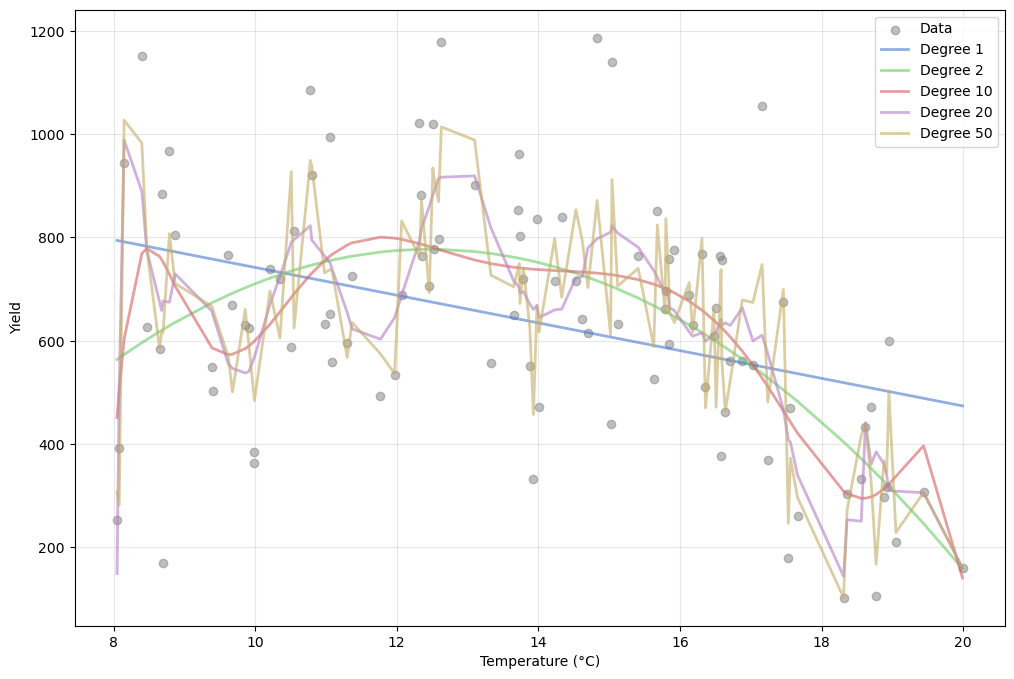

In [10]:
# Plot the predictions of the models
fig, ax = plt.subplots(figsize=(12, 8))

# 1000 points between the min and max of X
xs = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1) 

# Plot the data
ax.scatter(X, y, label="Data", color="gray", alpha=0.5)

# Iterate over the models and plot the predictions
for i in range(len(degrees)):
    Xp = poly(X, degrees[i])
    ax.plot(X, models[i].predict(Xp), label=f"Degree {degrees[i]}", lw=2,
            alpha=0.6)


# Aesthetics
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Yield")
ax.grid(alpha=0.3)
ax.legend()

#### ➡️ ✏️ Task 2

Did you notice that the MSE of the model steadily drops as the number of polynomials increases? This is because the model is becoming more and more complex, and it is able to fit the training data better and better. However, this does not mean that the model is becoming better and better. In fact, as we have discussed in class, a model that is too complex can lead to **overfitting**.

Which model do you think is the best? Why? Discuss with your classmates.

___

## Training, Validation, and Testing Datasets

When developing a machine learning model, a primary goal is ensuring its predictions are robust and reliable on new, unseen data. To achieve this, data scientists commonly partition their dataset into three distinct subsets: the **training set**, the **validation set**, and the **testing set**.

- **Training Set**: This subset of data is utilized to *"train"* or *"fit"* the model. It allows the model to identify and learn from patterns, relationships, and structures present within the data.

- **Validation Set**: After the training process, this subset is used to fine-tune model parameters and choose between different model complexities. It helps in selecting the best-performing model without touching the test data, thereby mitigating the risk of overfitting.

- **Testing Set**: Kept entirely separate from the training and validation process, this subset assesses the model's final performance, providing insights into its ability to generalize to new, unseen data.

The practice of dividing the data in this manner aligns with the **Empirical Risk Minimization (ERM)** principle. Adhering to ERM, when presented with multiple models, there's a natural inclination to opt for the most complex one as it typically exhibits the smallest error on the training data. However, this can be a pitfall. Although a complex model may seem to perfectly fit the training data, it might also be capturing its inherent noise, leading to **overfitting**.

**Overfitting** is characterized by a model's excessive adaptation to the training data, to the point where it becomes overly sensitive to its intricacies, including outliers and anomalies. Consequently, while it may shine on the training set, its performance tends to falter on the testing set, reflecting poor generalization.

Conversely, **Underfitting** denotes a situation where a model, due to its overly simplistic nature or inadequate training, fails to discern the core patterns within the data. Unlike overfitting, an underfitted model underperforms on both the training and testing sets. It lacks the necessary depth to encapsulate the richness and intricacies of the data, making its predictions suboptimal.

By allocating data to training, validation, and testing subsets, we can meticulously calibrate our model. This approach ensures that the model not only captures essential patterns but also retains its ability to generalize, making it a reliable tool for real-world applications.

In this notebook, we will begin by keeping things simple. We will only build a training and a testing set. We will not perform model selection or hyperparameter tuning. We will leave these topics for the next notebook.


#### ➡️ ✏️ Task 3

Take time to understand the code and the plot below. In small groups of 3-4 students. Explain to each other what is happening in the plot below. In particular, 
+ Explain why the MSE of the model on the training data is steadily decreasing, while the MSE of the model on the test data is first decreasing and then increasing. 
+ Explain which model is overfitting? Which model is underfitting? Which model is the best?
+ Discuss whether it is possible that the test error is lower than the training error.

In [11]:
# sklearn provides a function to split data into two separate sets
# We could easily implement this ourselves, but it's convenient to use
# the sklearn version
from sklearn.model_selection import train_test_split

In [12]:
# Load a new dataset, the US crop yields data with more observations
crops = pd.read_csv("data/us_crops_900.csv")
crops.head()

,temp,yield
0,16.64,462.771538
1,11.37,725.362676
2,12.52,776.967318
3,13.79,718.718013
4,11.97,533.642120


In [13]:
# Create a matrix of polynomials up to degree `max_degree`
max_degree = 30 # Maximum degree to model
X = poly(crops["temp"], max_degree)
y = crops["yield"]

# Split the data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)

In [14]:
# Lists of the mean squared errors on the train and test sets
mse_train = []
mse_test = []


degrees = range(1, max_degree + 1) # Degrees to model

for degree in degrees:
    # Fit a linear regression model to the polynomial features (up to degree)
    model = LinearRegression().fit(X_train[:, :degree], y_train)

    # Compute the predictions on the train and test sets
    y_hat_train = model.predict(X_train[:, :degree])
    y_hat_test = model.predict(X_test[:, :degree])

    # Compute the mean squared error on the train and test sets
    mse_train.append(mse(y_train, y_hat_train))
    mse_test.append(mse(y_test, y_hat_test))

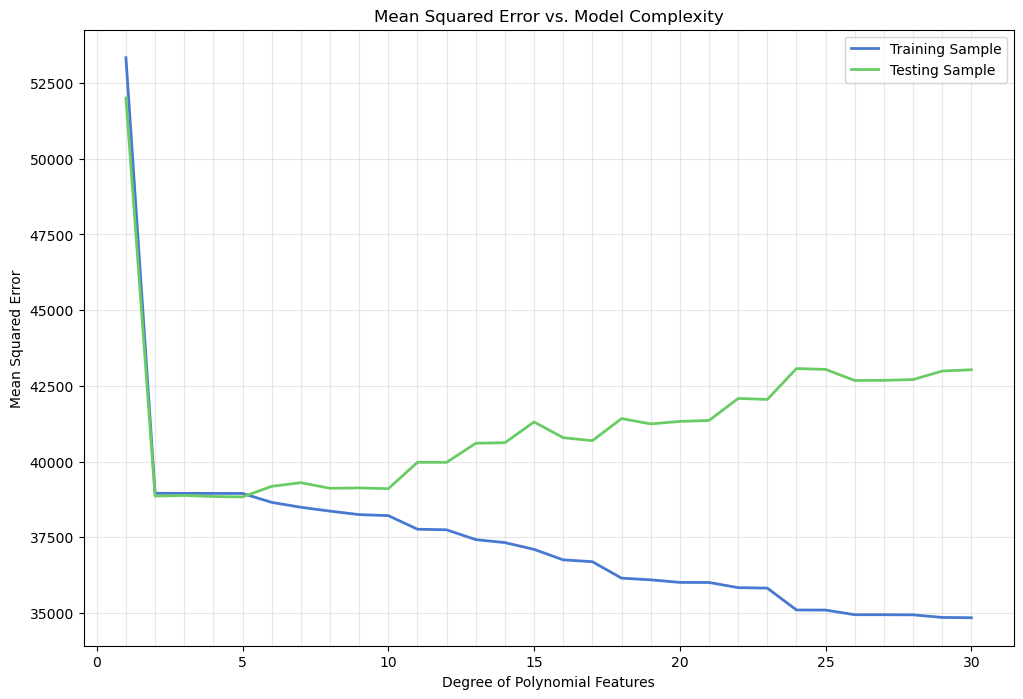

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the mean squared errors on the train and test sets
ax.plot(degrees, mse_train, label="Training Sample", lw=2)
ax.plot(degrees, mse_test, label="Testing Sample", lw=2)

# Aesthetics
ax.set_title("Mean Squared Error vs. Model Complexity")
ax.set_xlabel("Degree of Polynomial Features")
ax.set_ylabel("Mean Squared Error")
# Add minor ticks every 1 degree for the x-axis
ax.set_xticks(range(0, max_degree), minor=True)
# Turn on the grid for major and minor ticks
ax.grid(which='both', alpha=0.3)
# Turn off minor tick labels
ax.tick_params(which='minor', size=0)
ax.legend()

#### ➡️ ✏️ Task 4

You have learned about Ridge and Lasso regularization in class yesterday. `scikit-learn` provides these methods in the `Ridge` and `Lasso` classes the same way it provides linear regression.

1. Using the code below, fit a Ridge and a Lasso model to the data. Repeat the plot from Task 3 but now for the Ridge and Lasso models.
2. Try changing the regularization parameter (`alpha` in `Ridge` and `Lasso`) and see how it affects the training and testing errors.


In [16]:
from sklearn.linear_model import Ridge, Lasso

In [18]:
# Define the models
ridge = Ridge(alpha=1)
lasso = Lasso(alpha=1)

In [19]:
# Lists of the mean squared errors on the train and test sets
mse_train_lasso = []
mse_test_lasso = []
mse_train_ridge = []
mse_test_ridge = []


degrees = range(1, max_degree + 1) # Degrees to model

for degree in degrees:
    # Fit lasso and ridge (up to a certain degree of polynomial)
    lasso = lasso.fit(X_train[:, :degree], y_train)
    ridge = ridge.fit(X_train[:, :degree], y_train)

    # Compute the predictions on the train and test sets
    y_hat_train_lasso = lasso.predict(X_train[:, :degree])
    y_hat_test_lasso = lasso.predict(X_test[:, :degree])
    y_hat_train_ridge = ridge.predict(X_train[:, :degree])
    y_hat_test_ridge = ridge.predict(X_test[:, :degree])

    # Compute the mean squared error on the train and test sets
    mse_train_lasso.append(mse(y_train, y_hat_train_lasso))
    mse_test_lasso.append(mse(y_test, y_hat_test_lasso))
    mse_train_ridge.append(mse(y_train, y_hat_train_ridge))
    mse_test_ridge.append(mse(y_test, y_hat_test_ridge))

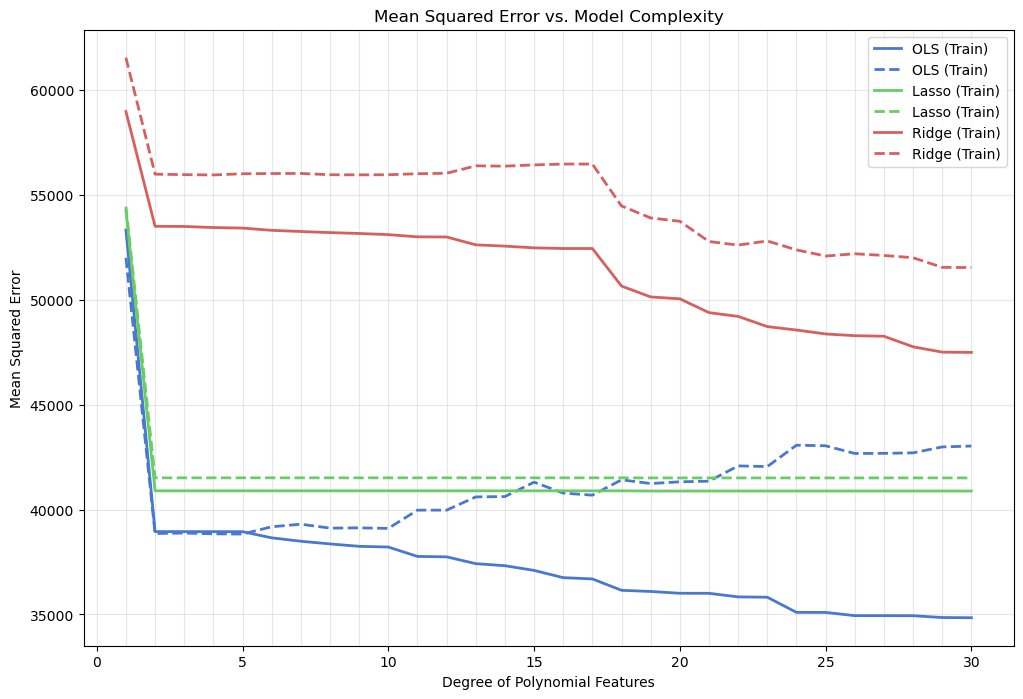

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the mean squared errors on the train and test sets
ax.plot(degrees, mse_train, label="OLS (Train)", lw=2, c="C0")
ax.plot(degrees, mse_test, label="OLS (Train)", lw=2, c="C0", ls="--")
ax.plot(degrees, mse_train_lasso, label="Lasso (Train)", lw=2, c="C1")
ax.plot(degrees, mse_test_lasso, label="Lasso (Train)", lw=2, c="C1", ls="--")
ax.plot(degrees, mse_train_ridge, label="Ridge (Train)", lw=2, c="C2")
ax.plot(degrees, mse_test_ridge, label="Ridge (Train)", lw=2, c="C2", ls="--")

# Aesthetics
ax.set_title("Mean Squared Error vs. Model Complexity")
ax.set_xlabel("Degree of Polynomial Features")
ax.set_ylabel("Mean Squared Error")
# Add minor ticks every 1 degree for the x-axis
ax.set_xticks(range(0, max_degree), minor=True)
# Turn on the grid for major and minor ticks
ax.grid(which='both', alpha=0.3)
# Turn off minor tick labels
ax.tick_params(which='minor', size=0)
ax.legend()